# 1. Import Libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
import pytorch_lightning as pl
import torchmetrics
import torch.nn.functional as F
import wandb


from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchinfo import summary
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger


from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ufuksecilmis. Use `wandb login --relogin` to force relogin


True

# 2.Select Device

In [3]:
has_gpu = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print(f"Target device is {device}")


# Some hyperparameters
random_seed = 1
batch_size = 64
learning_rate = 1e-3
num_epochs = 50
num_classes = 1
image_width,image_height = (224,224)

GPU is available
Target device is cuda


In [4]:
training_data_dir   = 'C:\\Users\\ufuks\\Documents\\Master\\hymenoptera_data\\hymenoptera_data\\train\\'
test_data_dir       = 'C:\\Users\\ufuks\\Documents\\Master\\hymenoptera_data\\hymenoptera_data\\val\\'

# 3.Creating Data Transforms for Preprocessing

In [5]:
train_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.AutoAugment(transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

test_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),                   
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
    ])

In [6]:
# ImageFolder
train_dataset = ImageFolder(training_data_dir,transform = train_data_transform)
test_dataset =  ImageFolder(test_data_dir,transform = test_data_transform)

# 4. Creating DataLoader for mini-batches

In [7]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)

# 5. Visualize the data

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([64, 3, 224, 224])


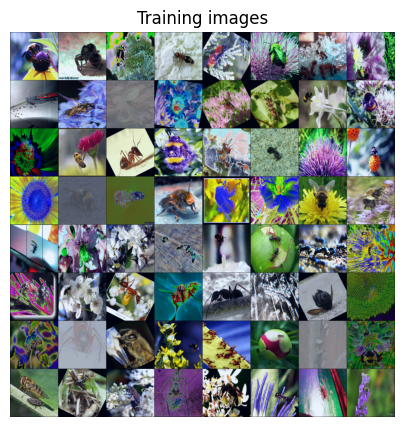

Labels = 
[[1 0 1 0 1 1 0 1]
 [0 1 0 1 1 1 1 1]
 [1 1 0 1 0 0 1 1]
 [1 1 0 1 1 0 1 1]
 [0 1 1 0 1 0 0 1]
 [0 1 0 1 0 0 1 1]
 [1 0 1 1 0 0 0 1]
 [1 0 1 0 1 0 0 1]]


In [8]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1].data.numpy().reshape(8,8))

# 6.Model

In [10]:
class ResNet18(pl.LightningModule):
    def __init__(self, learning_rate, num_classes):
        
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.train_acc = torchmetrics.classification.BinaryAccuracy()
        self.val_acc = torchmetrics.classification.BinaryAccuracy()
        self.test_acc = torchmetrics.classification.BinaryAccuracy()
        self.f1 = torchmetrics.classification.BinaryF1Score()
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Change the fully connected layer. I have 2 classes
        self.model.fc = torch.nn.Sequential(torch.nn.Linear(512, self.num_classes))
        
        
        self.save_hyperparameters()
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def _shared_step(self, batch):
        x , y = batch
        logits = self(x)
        m = torch.nn.Sigmoid()
        loss = F.binary_cross_entropy_with_logits(logits, y.unsqueeze(1).float())
        predicted_labels = torch.round(m(logits)).reshape(-1)
        f1 = self.f1(predicted_labels, y)
        return loss, y, predicted_labels, f1
    
    def training_step(self, batch, batch_idx):
        loss, y, predicted_labels, f1 = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, y)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, y, predicted_labels, f1 = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, y)
        self.log("val_acc", self.val_acc, prog_bar=True)
        self.log("val_f1", f1, on_epoch=True, sync_dist=True)
        return loss

    
    def test_step(self, batch, batch_idx):
        loss, y, predicted_labels, f1 = self._shared_step(batch)
        self.test_acc(predicted_labels, y)
        self.log("test_acc", self.test_acc)
        self.log("test_f1_macro", f1, on_epoch=True, sync_dist=True)
        return loss
    
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# 7.Training

In [11]:
model = ResNet18(learning_rate = learning_rate, num_classes = num_classes)

# save top 1 model
checkpoint_callback = ModelCheckpoint(
    dirpath = 'C:\\Users\\ufuks\\Documents\\WSI\\Model\\Pytorch Tutorial\\Checkpoints_Ant_Bee\\',
    save_top_k=1,
    save_last = True,
    mode="max", monitor="val_acc",
    filename="ResNet18_BceLoss-{epoch:02d}-{val_acc:.4f}")


# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='Ant_Bee_ResNet18_BCELoss')
wandb_logger.experiment.config["batch_size"] = batch_size



trainer = pl.Trainer(
                     accelerator = 'gpu', 
                     devices = -1, 
                     min_epochs = 1, 
                     max_epochs = 50, 
                     precision = 16,
                     callbacks=checkpoint_callback,
                     deterministic = True,
                     logger=wandb_logger
                     )

wandb_logger.watch(model)
trainer.fit(model, train_loader, test_loader)

C:\Users\ufuks\miniconda3\envs\torch\lib\site-packages\lightning_fabric\connector.py:555: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\ufuks\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Che

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\ufuks\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


# 8. Test the Model

In [15]:
# save top 1 model
checkpoint_callback = ModelCheckpoint(
    dirpath = 'C:\\Users\\ufuks\\Documents\\WSI\\Model\\Pytorch Tutorial\\Checkpoints_Ant_Bee\\',
    save_top_k=1,
    save_last = True,
    mode="max", monitor="val_acc",
    filename="ResNet18_BceLoss-{epoch:02d}-{val_acc:.4f}")
wandb_logger = WandbLogger(project='Ant_Bee_ResNet18_BCELoss')
trainer = pl.Trainer(
                     accelerator = 'gpu', 
                     devices = -1, 
                     min_epochs = 1, 
                     max_epochs = 50, 
                     precision = 16,
                     callbacks=checkpoint_callback,
                     deterministic = True,
                     logger=wandb_logger
                     )
checkpoint_path = 'C:\\Users\\ufuks\\Documents\\WSI\\Model\\Pytorch Tutorial\\Checkpoints_Ant_Bee\\ResNet18_BceLoss-epoch=24-val_acc=0.9150.ckpt'
model = ResNet18.load_from_checkpoint(checkpoint_path)
trainer.test(model, test_loader)
#wandb.finish()

C:\Users\ufuks\miniconda3\envs\torch\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
C:\Users\ufuks\miniconda3\envs\torch\lib\site-packages\lightning_fabric\connector.py:555: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details,

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.915032684803009     │
│       test_f1_macro       │    0.5486484169960022     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.915032684803009, 'test_f1_macro': 0.5486484169960022}]

# 9. Getting Predictions and Probabilities

In [16]:
model = model.to(device)
ground_truth_labels = []
predicted_labels = []
probs = []
m = torch.nn.Sigmoid()
with torch.no_grad():
    model = model.eval()
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probabilities = m(logits).reshape(-1)
        label_pred = torch.round(probabilities).reshape(-1)
        predicted_labels.extend(label_pred.cpu().numpy())
        ground_truth_labels.extend(labels.numpy())
        probs.extend(probabilities.cpu().numpy())

# 10. Confusion Matrix

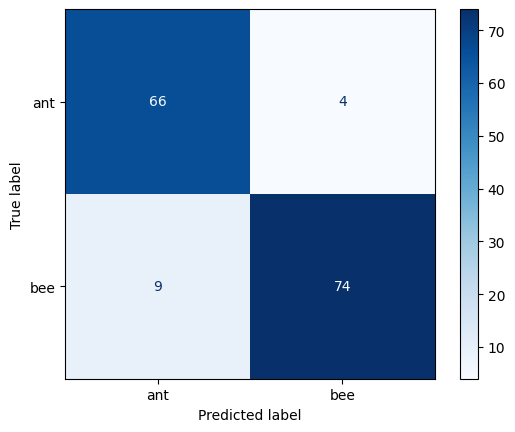

In [17]:
labels = ['ant', 'bee']
cm = confusion_matrix(ground_truth_labels, predicted_labels)
display = ConfusionMatrixDisplay(cm,display_labels=labels)
display.plot(cmap="Blues", values_format="d")
plt.show()

# 11. Classification Report 

In [18]:
print(classification_report(ground_truth_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

         ant       0.88      0.94      0.91        70
         bee       0.95      0.89      0.92        83

    accuracy                           0.92       153
   macro avg       0.91      0.92      0.91       153
weighted avg       0.92      0.92      0.92       153



# 13.ROC - AUC 

In [19]:
# roc curve for models
fpr, tpr, thresh = roc_curve(ground_truth_labels, probs, pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(ground_truth_labels))]
p_fpr, p_tpr, _ = roc_curve(ground_truth_labels, random_probs, pos_label=1)

In [20]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score = roc_auc_score(ground_truth_labels, probs)


print(auc_score)

0.9549053356282271


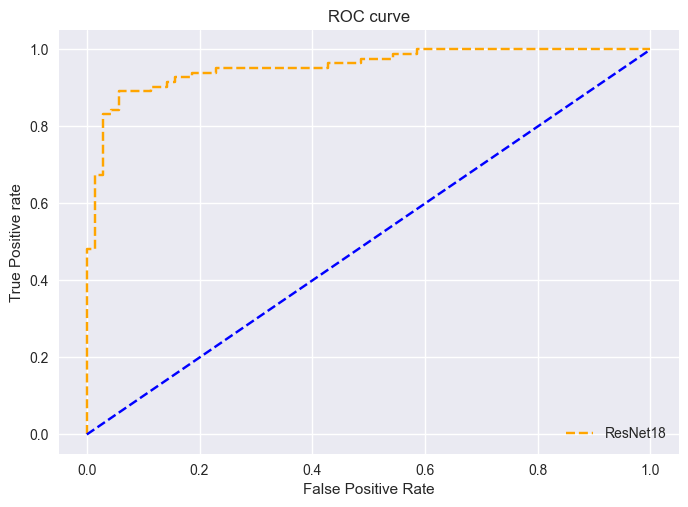

In [22]:
# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='ResNet18')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='lower right')
plt.show();

In [23]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███▁
test_acc,▁▁
test_f1_macro,█▁
train_acc,▁▄▅▄▅▆▆▇▇▇▇▇▇███████████████████████████
train_loss,█▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███▁
val_acc,▁▃▂▁▆▆▅▄████▇▇▇█████████████████████████
val_f1,▁▅▂██▇▆▅███▇▇▇▇▇████████████████████████
val_loss,▂▂▃█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,0
test_acc,0.91503
